In [1]:
import os
os.chdir("..")

import sys 
sys.path.append("../src")

In [2]:
from transformers import set_seed
from src.finetune.finetune_model import FinetuneModel
from src.parser.parser import parse_finetune_model
from src.data.dataset import get_finetuning_dataset
from src.utils.data_utils import FinetuningCollator
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.nn.functional import softmax

# Baseline CT23

In [3]:
class args:
    model="bert-base-cased"
    model_path="./models/pretrained_finetuned/BASELINE_BERT_CT23/best_model_4"
    callback=None
    important_word_token=False
    dataset="CT23"
    experiment_name=None
    num_epochs=0
    train_batch_size=16
    val_batch_size=32
    gradient_accumulation_steps=1
    optimizer="adamw"
    weight_decay=1e-2
    lr=2e-5
    scheduler="linear"
    metric="f1"
    warmup_ratio=0.1
    seed=42
    distributed=False
    not_pretrained=False
    weighted_loss=False
    load_only_model=True

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
set_seed(args.seed)

dataset_constructor = get_finetuning_dataset(args.dataset)
train_dataset = dataset_constructor(
    dataset_name=args.dataset, 
    split="train"
)

num_labels = train_dataset.get_num_labels()
model = FinetuneModel(
    model=args.model,
    model_path=args.model_path, 
    num_epochs=args.num_epochs, 
    experiment_name=args.experiment_name,
    metric=args.metric,
    num_labels=num_labels,
    device=device, 
    distributed=args.distributed,
    not_pretrained=args.not_pretrained,
    loss_weights=train_dataset.calculate_weights() if args.weighted_loss else None,
    load_only_model=args.load_only_model
)

c = FinetuningCollator(
    model=model,
    model_tag=args.model,
    add_important_word_token=args.important_word_token
)

test_dataset = dataset_constructor(
    dataset_name=args.dataset, 
    split="test"
)
test_dataloader = DataLoader(
    test_dataset, 
    batch_size=args.val_batch_size, 
    collate_fn=c.collate_fn
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [5]:
def embed_dataset():
    all_embeddings = []
    all_labels = []
    
    with torch.no_grad():
        for b in tqdm(test_dataloader):
            inputs, labels = b
            inputs = {k:v.to(device) for k,v in inputs.items()}
            outs = model.model(**inputs).last_hidden_state[:, 0, :]
            
            all_embeddings.extend(outs.cpu().detach().numpy())
            all_labels.extend(labels.numpy())
    
    return np.array(all_embeddings), np.array(all_labels)

embeddings, labels = embed_dataset()

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.24it/s]


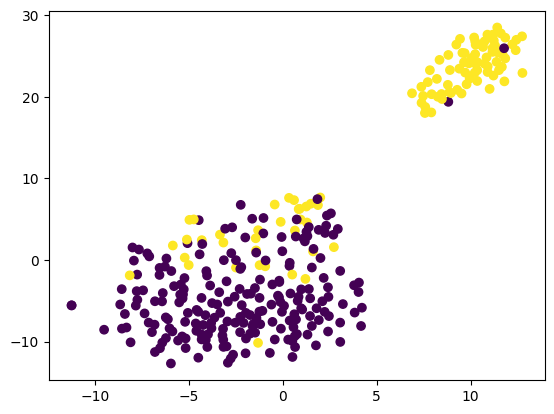

In [6]:
def dim_reduction_and_plot(model_name, labels, embeddings, method_kwargs={}, method=TSNE):
    embedded = method(**method_kwargs).fit_transform(embeddings)
    plt.scatter(embedded[:, 0], embedded[:, 1], c=labels)
    return embedded

embs = dim_reduction_and_plot(args.model, labels, embeddings)

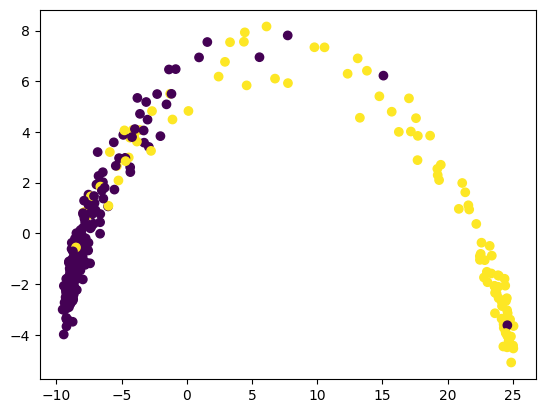

In [7]:
embed = dim_reduction_and_plot(args.model, labels, embeddings, {"n_components":2}, PCA)

In [8]:
def forward_dataloader():
    all_probs = []
    
    with torch.no_grad():
        for b in tqdm(test_dataloader):
            inputs, labels = b
            inputs = {k:v.to(device) for k,v in inputs.items()}
            outs = model(inputs)
            outs = softmax(outs, dim=1)
            all_probs.extend(outs.cpu().detach().numpy())
    
    return np.array(all_probs)

out = forward_dataloader() 

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 19.43it/s]


In [9]:
def get_hardest_indices(k=10):
    out_correct = out[np.arange(out.shape[0]), labels.astype(int)]
    diffs = np.abs(out_correct - 1)

    d = [(i, j) for i, j in enumerate(diffs)]
    d = sorted(d, key=lambda x: x[1], reverse=True)
    return np.array(d[:k])[:, 0].astype(int), np.array(d[:k])[:, 1]

def print_hardest(map_dict):
    indices, confidences = get_hardest_indices()
    for idx, (i,j) in enumerate(zip(indices, confidences)):
        ex = test_dataset[i]
        print(fr"{idx} & {ex[0]} & {map_dict[int(ex[1])]} \\")
        print("\\hline")
    
print_hardest({1:"Yes", 0:"No"})

0 & He thinks wind causes cancer, windmills. & Yes \\
\hline
1 & The general who was with him said All he ever wants to do is divide people not unite people at all. & Yes \\
\hline
2 & The Green New Deal is not my plan... & Yes \\
\hline
3 & So why didn't he do it for 47 years? & Yes \\
\hline
4 & And the fact is, I've made it very clear, within 100 days, I'm going to send to the United States Congress a pathway to citizenship for over 11 million undocumented people. & No \\
\hline
5 & And we're in a circumstance where the President, thus far, still has no plan. & Yes \\
\hline
6 & Many of your Democrat Governors said, \President Trump did a phenomenal job.\"" & Yes \\
\hline
7 & Yeah, you did say that. & Yes \\
\hline
8 & Some of these ballots in some states can't even be opened until election day. & Yes \\
\hline
9 & Because it costs a lot of money to open them safely. & Yes \\
\hline


 # Selective MLM pretrained  CT23

In [10]:
class args:
    model="bert-base-cased"
    model_path="./models/pretrained_finetuned/FINETUNE_BEST_BERT_SELECTIVE_MLM_CT23_79/best_model_5"
    callback=None
    important_word_token=False
    dataset="CT23"
    experiment_name=None
    num_epochs=0
    train_batch_size=16
    val_batch_size=32
    gradient_accumulation_steps=1
    optimizer="adamw"
    weight_decay=1e-2
    lr=2e-5
    scheduler="linear"
    metric="f1"
    warmup_ratio=0.1
    seed=42
    distributed=False
    not_pretrained=False
    weighted_loss=False
    load_only_model=True

device = "cuda:0" if torch.cuda.is_available() else "cpu"
set_seed(args.seed)

dataset_constructor = get_finetuning_dataset(args.dataset)
train_dataset = dataset_constructor(
    dataset_name=args.dataset, 
    split="train"
)

num_labels = train_dataset.get_num_labels()
model = FinetuneModel(
    model=args.model,
    model_path=args.model_path, 
    num_epochs=args.num_epochs, 
    experiment_name=args.experiment_name,
    metric=args.metric,
    num_labels=num_labels,
    device=device, 
    distributed=args.distributed,
    not_pretrained=args.not_pretrained,
    loss_weights=train_dataset.calculate_weights() if args.weighted_loss else None,
    load_only_model=args.load_only_model
)

c = FinetuningCollator(
    model=model,
    model_tag=args.model,
    add_important_word_token=args.important_word_token
)

test_dataset = dataset_constructor(
    dataset_name=args.dataset, 
    split="test"
)
test_dataloader = DataLoader(
    test_dataset, 
    batch_size=args.val_batch_size, 
    collate_fn=c.collate_fn
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [11]:
embeddings, labels = embed_dataset()

100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.86it/s]


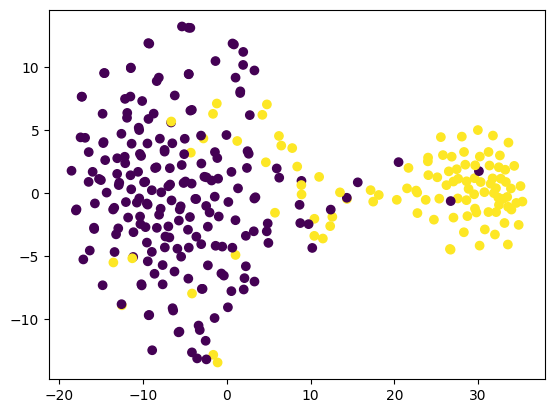

In [12]:
embed = dim_reduction_and_plot(args.model, labels, embeddings)

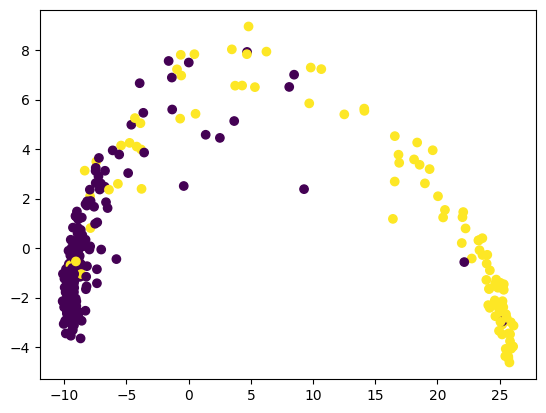

In [13]:
embed = dim_reduction_and_plot(args.model, labels, embeddings, {"n_components":2}, PCA)

In [14]:
out = forward_dataloader() 

print_hardest({1:"Yes", 0:"No"})

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 15.39it/s]

0 & He thinks wind causes cancer, windmills. & Yes \\
\hline
1 & We took away the individual mandate. & Yes \\
\hline
2 & And we're in a circumstance where the President, thus far, still has no plan. & Yes \\
\hline
3 & And it's gone through, including the Democrats, in all fairness. & Yes \\
\hline
4 & The individual mandate -- where you have to pay a fortune for the privilege of not having to pay for bad health insurance. & Yes \\
\hline
5 & The places we had trouble were Democratic-run cities... & Yes \\
\hline
6 & Manufacturing went in a hole- & Yes \\
\hline
7 & Dr. Fauci said the opposite. & Yes \\
\hline
8 & So why didn't he do it for 47 years? & Yes \\
\hline
9 & Many of your Democrat Governors said, \President Trump did a phenomenal job.\"" & Yes \\
\hline


# Baseline FEVER

In [15]:
class args:
    model="bert-base-cased"
    model_path="./models/pretrained_finetuned/BASELINE_BERT_FEVER/best_model_9"
    callback=None
    important_word_token=False
    dataset="FEVER"
    experiment_name=None
    num_epochs=0
    train_batch_size=16
    val_batch_size=32
    gradient_accumulation_steps=1
    optimizer="adamw"
    weight_decay=1e-2
    lr=2e-5
    scheduler="linear"
    metric="f1"
    warmup_ratio=0.1
    seed=42
    distributed=False
    not_pretrained=False
    weighted_loss=False
    load_only_model=True

In [16]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
set_seed(args.seed)

dataset_constructor = get_finetuning_dataset(args.dataset)
train_dataset = dataset_constructor(
    dataset_name=args.dataset, 
    split="train"
)

num_labels = train_dataset.get_num_labels()
model = FinetuneModel(
    model=args.model,
    model_path=args.model_path, 
    num_epochs=args.num_epochs, 
    experiment_name=args.experiment_name,
    metric=args.metric,
    num_labels=num_labels,
    device=device, 
    distributed=args.distributed,
    not_pretrained=args.not_pretrained,
    loss_weights=train_dataset.calculate_weights() if args.weighted_loss else None,
    load_only_model=args.load_only_model
)

c = FinetuningCollator(
    model=model,
    model_tag=args.model,
    add_important_word_token=args.important_word_token
)

test_dataset = dataset_constructor(
    dataset_name=args.dataset, 
    split="test"
)
test_dataloader = DataLoader(
    test_dataset, 
    batch_size=args.val_batch_size, 
    collate_fn=c.collate_fn
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [17]:
embeddings, labels = embed_dataset()

100%|█████████████████████████████████████████| 502/502 [01:01<00:00,  8.10it/s]


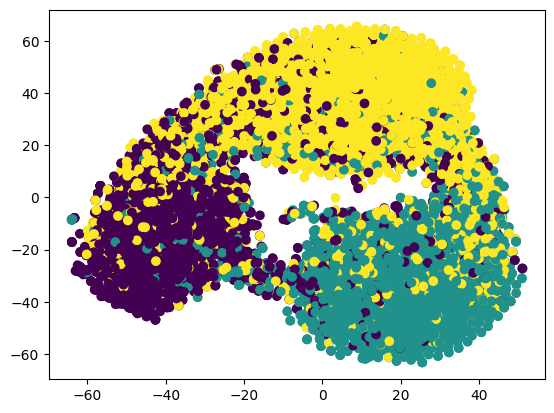

In [18]:
embed = dim_reduction_and_plot(args.model, labels, embeddings)

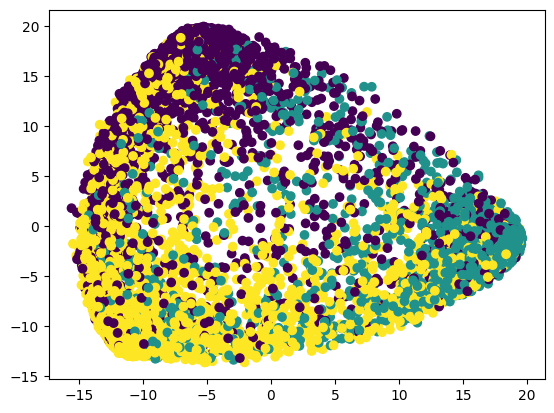

In [19]:
embed = dim_reduction_and_plot(args.model, labels, embeddings, {"n_components":2}, PCA)

In [20]:
out = forward_dataloader() 

100%|█████████████████████████████████████████| 502/502 [01:02<00:00,  8.06it/s]


In [26]:
def get_hardest_indices(k=10):
    out_correct = out[np.arange(out.shape[0]), labels.astype(int)]
    out_max = out.max(axis=1) 
    diffs = np.abs(out_max - out_correct)

    d = [(i, j, k) for i, (j, k) in enumerate(zip(diffs, out.argmax(axis=1) ))]
    d = sorted(d, key=lambda x: x[1], reverse=True)
    
    return np.array(d[:k])[:, 0].astype(int), np.array(d[:k])[:, 1], np.array(d[:k])[:, 2]

def print_hardest_FEVER(map_dict):
    indices, confidences, missed_class = get_hardest_indices(5)
    print(missed_class)
    for idx, (i,j,k) in enumerate(zip(indices, confidences, missed_class)):
        ex = test_dataset[i]
        print(fr"{idx} & {ex[0][0]} & {(' '.join(ex[0][1])).replace('-LRB-', '(').replace('-RRB-', ')')} & {map_dict[int(ex[1])]} \\")
        print("\\hline")

In [27]:
print_hardest_FEVER({
    0:"REFUTES", 
    1:"SUPPORTS", 
    2:"NOT ENOUGH INFO",
})

[2. 2. 2. 2. 0.]
0 & Pulmonary embolism is indicated by low blood oxygen levels. & Signs of a PE include low blood oxygen levels , rapid breathing , rapid heart rate , and sometimes a mild fever . & SUPPORTS \\
\hline
1 & Mandy Moore is a musician. & Outside of her musical career , Moore has also branched out into acting . & SUPPORTS \\
\hline
2 & Elizabeth of York was married to King George. & As the wife of Henry VII , she was the first Tudor queen . & REFUTES \\
\hline
3 & Ayananka Bose is a cinematographer. & Ayananka Bose is an Indian cinematographer of Bollywood movies . & SUPPORTS \\
\hline
4 & The Block (album)'s official single, released in 2008, is "Summertime". & The first official single from the album is `` Summertime '' and the song was released on May 13 , 2008 . & SUPPORTS \\
\hline


 # Selective MLM pretrained  FEVER

In [28]:
class args:
    model="bert-base-cased"
    model_path="./models/pretrained_finetuned/FINETUNE_BEST_BERT_SELECTIVE_MLM_FEVER_79/best_model_9"
    callback=None
    important_word_token=False
    dataset="FEVER"
    experiment_name=None
    num_epochs=0
    train_batch_size=16
    val_batch_size=32
    gradient_accumulation_steps=1
    optimizer="adamw"
    weight_decay=1e-2
    lr=2e-5
    scheduler="linear"
    metric="f1"
    warmup_ratio=0.1
    seed=42
    distributed=False
    not_pretrained=False
    weighted_loss=False
    load_only_model=True

In [30]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
set_seed(args.seed)

dataset_constructor = get_finetuning_dataset(args.dataset)
train_dataset = dataset_constructor(
    dataset_name=args.dataset, 
    split="train"
)

num_labels = train_dataset.get_num_labels()
model = FinetuneModel(
    model=args.model,
    model_path=args.model_path, 
    num_epochs=args.num_epochs, 
    experiment_name=args.experiment_name,
    metric=args.metric,
    num_labels=num_labels,
    device=device, 
    distributed=args.distributed,
    not_pretrained=args.not_pretrained,
    loss_weights=train_dataset.calculate_weights() if args.weighted_loss else None,
    load_only_model=args.load_only_model
)

c = FinetuningCollator(
    model=model,
    model_tag=args.model,
    add_important_word_token=args.important_word_token
)

test_dataset = dataset_constructor(
    dataset_name=args.dataset, 
    split="test"
)
test_dataloader = DataLoader(
    test_dataset, 
    batch_size=args.val_batch_size, 
    collate_fn=c.collate_fn
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [31]:
embeddings, labels = embed_dataset()

100%|█████████████████████████████████████████| 502/502 [01:02<00:00,  8.06it/s]


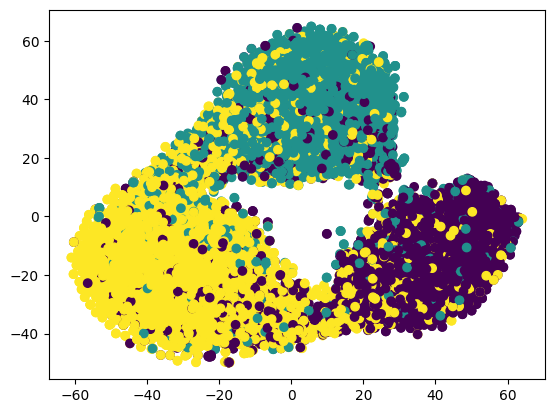

In [32]:
embed = dim_reduction_and_plot(args.model, labels, embeddings)

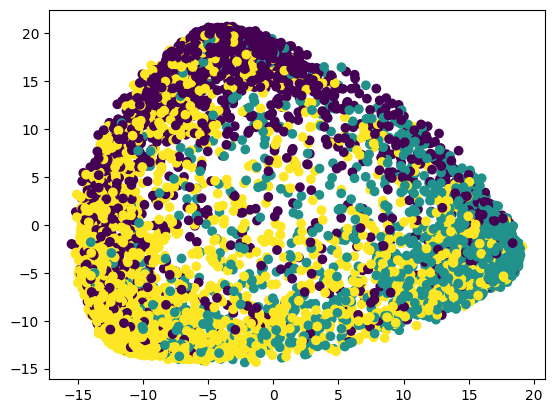

In [33]:
embed = dim_reduction_and_plot(args.model, labels, embeddings, {"n_components":2}, PCA)

In [34]:
out = forward_dataloader() 

100%|█████████████████████████████████████████| 502/502 [01:02<00:00,  8.04it/s]


In [35]:
print_hardest_FEVER({
    0:"REFUTES", 
    1:"SUPPORTS", 
    2:"NOT ENOUGH INFO",
})

[2. 2. 2. 2. 2.]
0 & Lorelai Gilmore's father is named Robert. & The dynamic of single parenthood and the tension between Lorelai and her wealthy parents , Richard ( Edward Herrmann ) and especially her controlling mother , Emily ( Kelly Bishop ) , form the main theme of the series story line . & REFUTES \\
\hline
1 & Color of Night won an award for an Olympic Event. & Nonetheless , it became one of the 20 most-rented films in the United States home video market in 1995 . & REFUTES \\
\hline
2 & Edouard Seguin worked in murdering. & Édouard Séguin ( January 20 , 1812 -- October 28 , 1880 ) was a physician and educationist born in Clamecy , Nièvre , France . & REFUTES \\
\hline
3 & Pearl (Steven Universe) projects a holographic butterfly. & She is a `` Gem '' , a fictional alien being that exists as a magical gemstone projecting a holographic body . & REFUTES \\
\hline
4 & Vic Mensa is a Japanese country singer. & Victor Kwesi Mensah ( born June 6 , 1993 ) , better known by his stage na